# DPT for hematopoiesis in mouse [Paul *et al.*, Cell (2015)](http://doi.org/10.1016/j.cell.2015.11.013)

Hematopoiesis: trace myeloid and erythroid differentiation for data of [Paul *et al.*, Cell (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

**Note:** For a more recent and richer analysis of this dataset take a look at https://github.com/theislab/graph_abstraction/tree/master/paul15.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/paul15.h5ad'

scanpy==1.3.1+83.g641af42 anndata==0.6.10+31.g4c40622 numpy==1.14.5 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

Perform a simple Diffusion Pseudotime analysis on raw data, as in [Haghverdi *et al.* (2016)](http://doi.org/10.1038/nmeth.3971). No preprocessing, only logarthmize the raw counts.

**Note**: The following function is also available as `sc.datasets.paul15()`.

In [3]:
adata = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical


In [4]:
sc.pp.log1p(adata)  # logarithmize data

In [5]:
sc.pp.neighbors(adata, n_neighbors=20, use_rep='X', method='gauss')

computing neighbors
    finished (0:00:01.95) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [6]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.992215   0.966011   0.9404994  0.9273089  0.88551635
     0.8672743  0.8413333  0.82867014 0.8070438  0.76248974 0.7282334
     0.7271825  0.7115725  0.69101715]
    finished (0:00:00.05) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)


In [7]:
sc.tl.dpt(adata, n_branchings=1, n_dcs=10)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.61) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs)


Diffusion Pseudotime (DPT) analysis detects the branch of granulocyte/macrophage progenitors (GMP), and the branch of megakaryocyte/erythrocyte progenitors (MEP). There are two small further subgroups (segments 0 and 2).

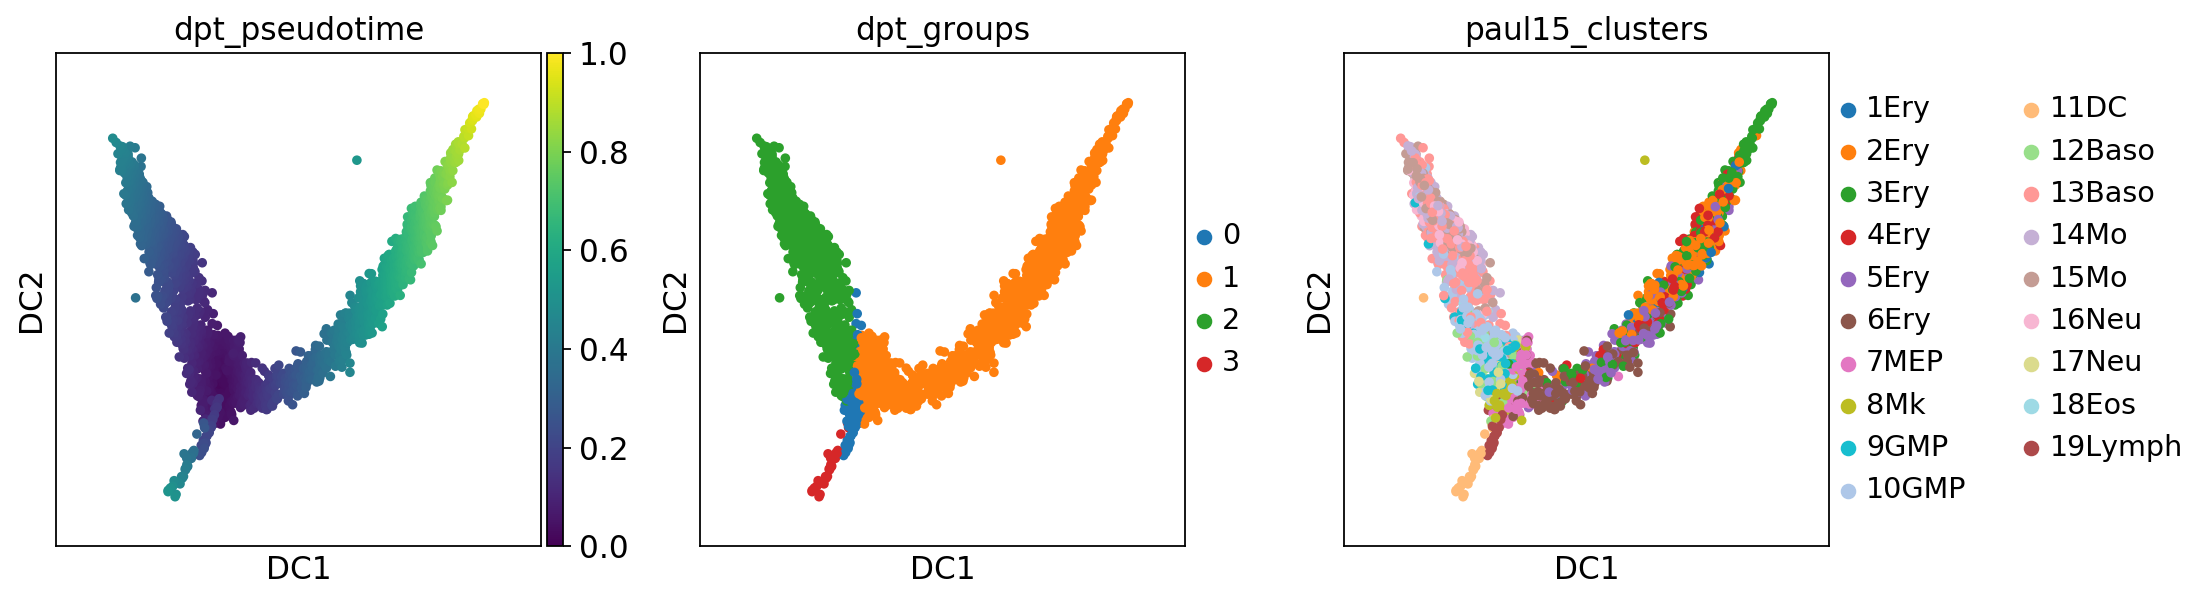

In [9]:
sc.pl.diffmap(adata, color=['dpt_pseudotime', 'dpt_groups', 'paul15_clusters'])

With this, we reproduced the analysis of [Haghverdi *et al.* (2016, Suppl. Note 4 and Suppl. Figure N4)](https://doi.org/10.1038/nmeth.3971).

In [10]:
adata.write(results_file)

Computing connectivities using UMAP gives us quantitiatively different results for the pseudotime.

In [11]:
sc.pp.neighbors(adata, n_neighbors=20, use_rep='X', method='umap')

computing neighbors
    finished (0:00:05.29) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [13]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.993715   0.9717146  0.95699656 0.94785434 0.9100064
     0.89768046 0.8868277  0.8667819  0.8511887  0.82064795 0.80687267
     0.7805664  0.77649134 0.7696744 ]
    finished (0:00:00.05) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)


In [14]:
sc.tl.dpt(adata, n_branchings=1)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.63) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs)


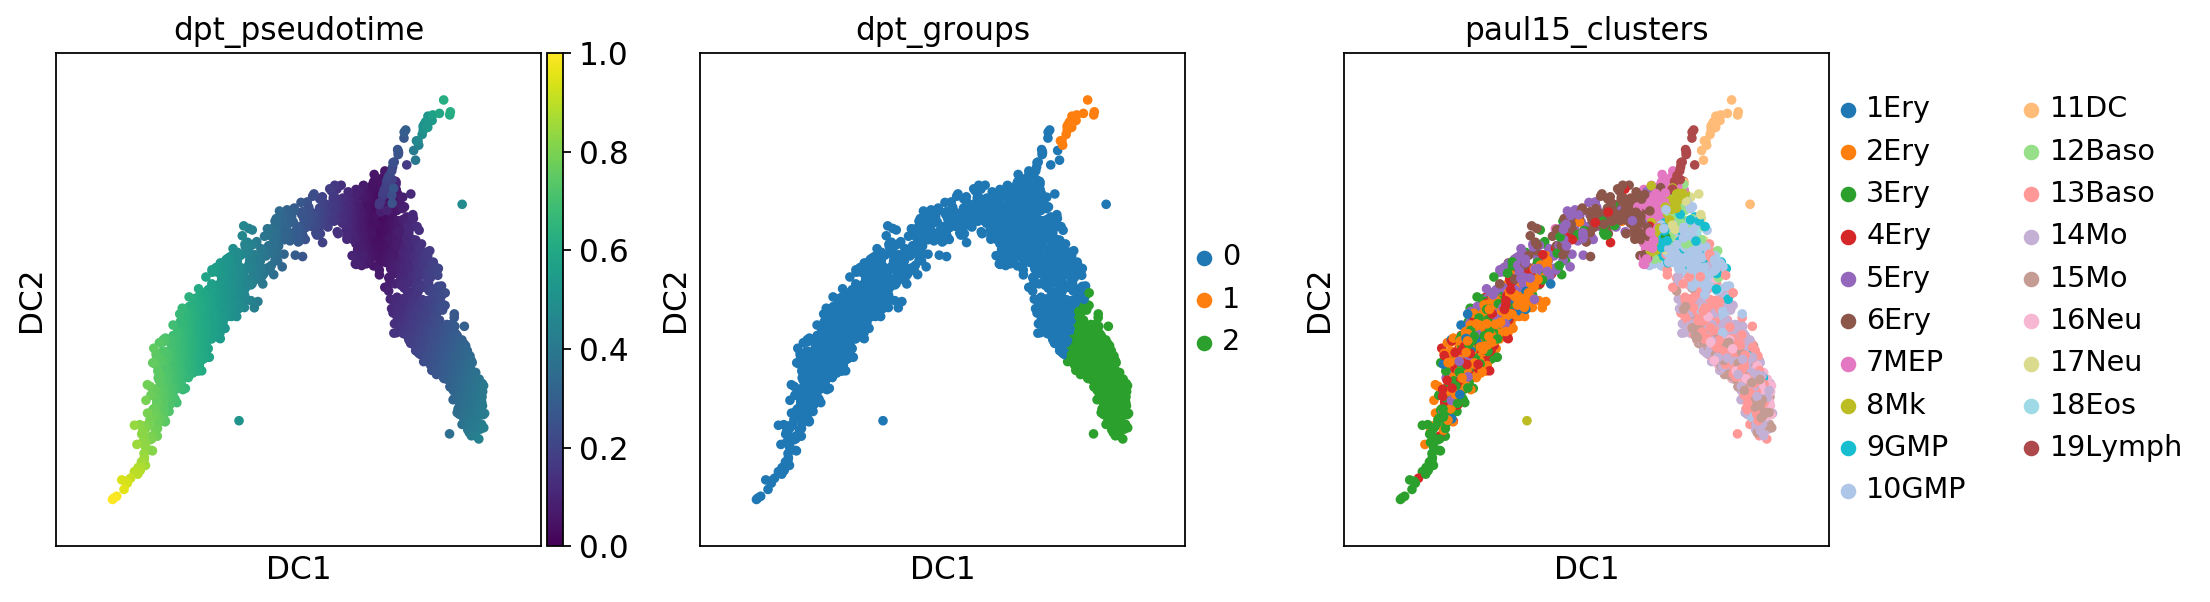

In [15]:
sc.pl.diffmap(adata, color=['dpt_pseudotime', 'dpt_groups', 'paul15_clusters'])